## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import os

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
KL_WEIGHT = 1e-9
LR = 1e-3
EPOCHS = 10
T = 10

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'A'
YEAR = 2019

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site A - 2019
(2235904, 28, 6) (2235904,)


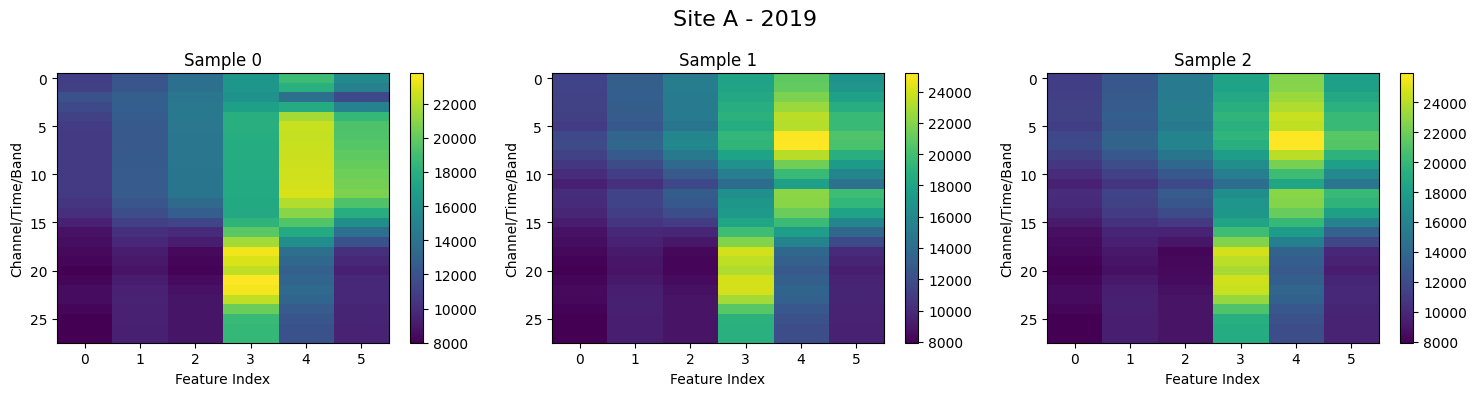

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site A - 2019 =======
Feature 0: Mean = 9125.7839, Std = 954.7112
Feature 1: Mean = 10072.9565, Std = 1117.6790
Feature 2: Mean = 10259.7823, Std = 1830.2272
Feature 3: Mean = 18465.9805, Std = 4748.0298
Feature 4: Mean = 16455.6007, Std = 3182.5979
Feature 5: Mean = 13576.9940, Std = 3438.3280

Global Mean: 12992.8496
Global Std Dev: 4532.1424


## Pre-processing the Input

In [6]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X_std = ((X - feature_means) / feature_stds).astype(np.float32)

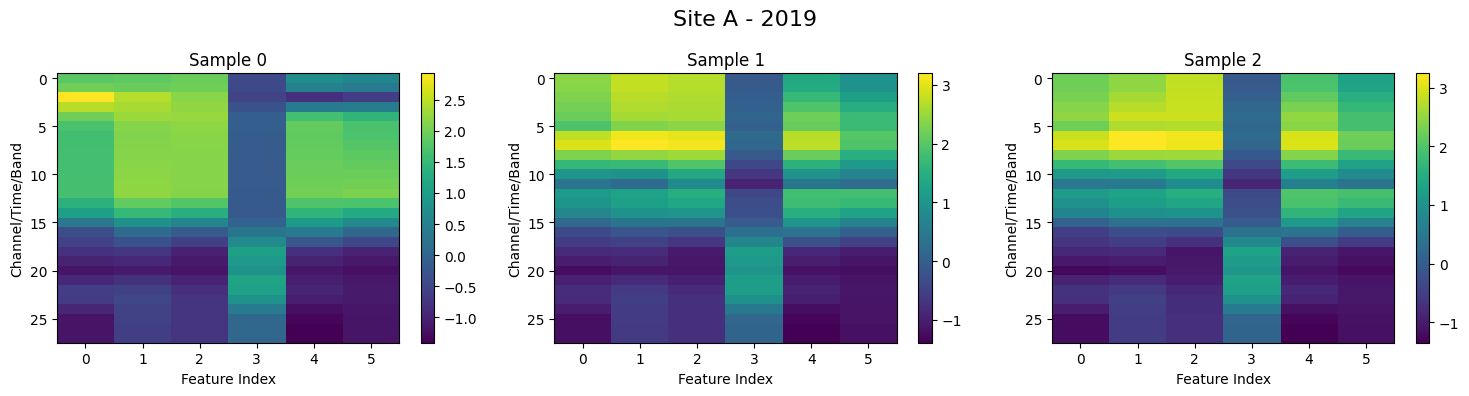

In [7]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X_std[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X_std.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_std.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_std.mean()
std = X_std.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site A - 2019 =======
Feature 0: Mean = 0.0000, Std = 0.8771
Feature 1: Mean = -0.0000, Std = 0.8871
Feature 2: Mean = -0.0000, Std = 0.8704
Feature 3: Mean = -0.0000, Std = 0.8796
Feature 4: Mean = 0.0000, Std = 0.8811
Feature 5: Mean = 0.0000, Std = 0.8545

Global Mean: -0.0000
Global Std Dev: 1.0000


## Taking Subset of the Data

In [9]:
# Taking only 25% percent of the data
X_subset, _, y_subset, _ = train_test_split(X_std, y, test_size=0.75, stratify=y, random_state=42)
print(X_subset.shape, y_subset.shape)

(558976, 28, 6) (558976,)


In [10]:
# Checking label distribution of the whole data
print('====== Label Distribution - Whole data ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")
    
print(f"\nTotal samples: {total}")

# Checking label distribution of the subset data
print('\n\n====== Label Distribution - Subset data ======')
unique_labels, counts = np.unique(y_subset, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

====== Label Distribution - Whole data ======
Label     Count     Percentage
------------------------------
0         391359    17.50%
1         1218750   54.51%
2         625795    27.99%

Total samples: 2235904


====== Label Distribution - Subset data ======
Label     Count     Percentage
------------------------------
0         97840     17.50%
1         304687    54.51%
2         156449    27.99%

Total samples: 558976


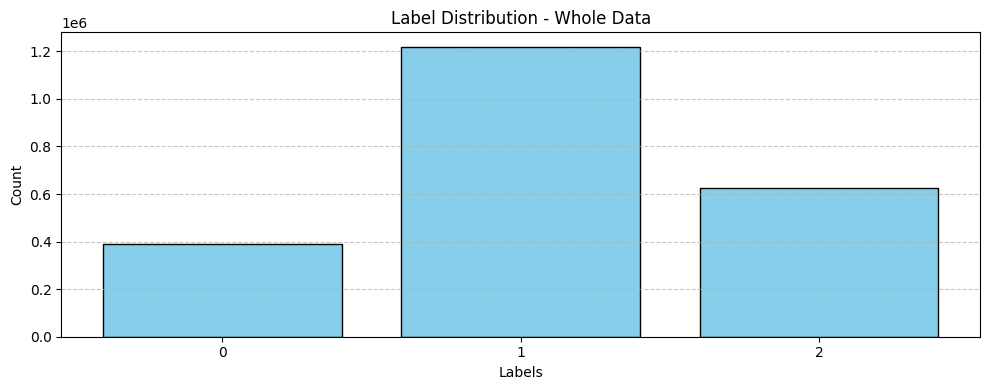

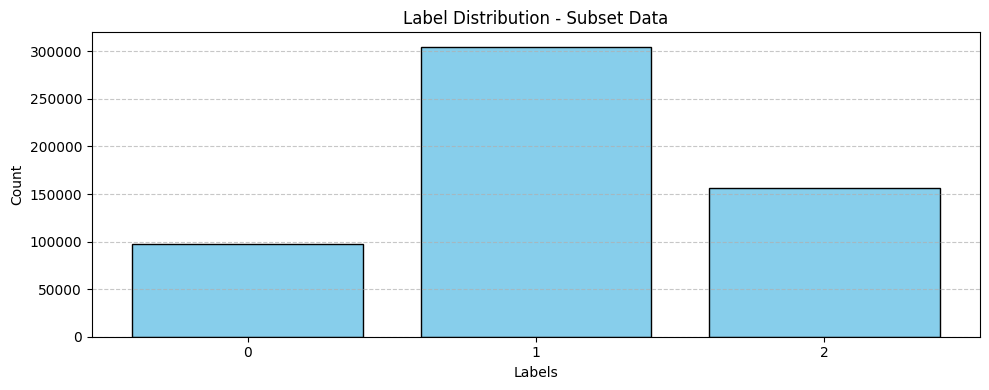

In [11]:
# Plot histogram for whole data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Whole Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot histogram for subset data
unique_labels, counts = np.unique(y_subset, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Subset Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Train/Val Split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(447180, 28, 6) (447180,)
(111796, 28, 6) (111796,)


In [13]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0003, Std = 0.9894
Feature 1: Mean = 0.0003, Std = 0.9884
Feature 2: Mean = 0.0003, Std = 0.9875
Feature 3: Mean = -0.0003, Std = 0.9919
Feature 4: Mean = 0.0003, Std = 0.9903
Feature 5: Mean = 0.0005, Std = 0.9924

Global Mean: 0.0002
Global Std Dev: 1.0000




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         78272     17.50%
1         243749    54.51%
2         125159    27.99%

Total samples: 447180


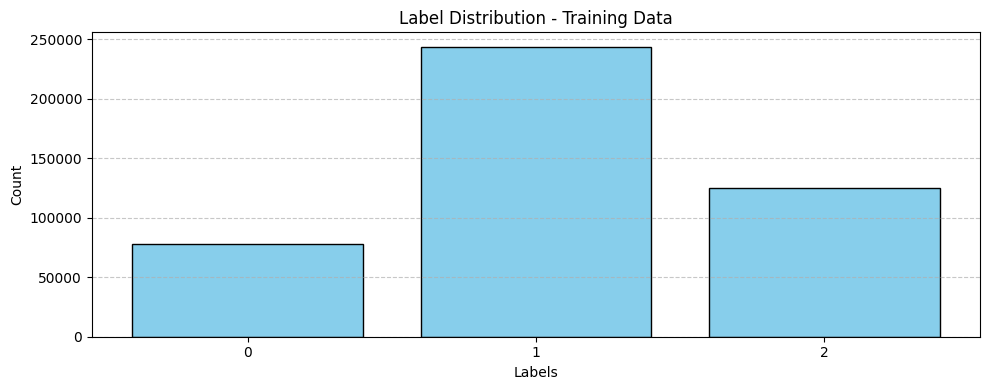

In [14]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [15]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
train_dataset = Conv1dDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

## Bayesian Layer Definitions

In [17]:
# KL Divergence Helper
########################################
def KL_DIV(mu_q, sig_q, mu_p, sig_p):
    return 0.5 * (2 * torch.log(sig_p / sig_q) - 1 +
                  (sig_q / sig_p).pow(2) +
                  ((mu_p - mu_q) / sig_p).pow(2)).sum()

In [18]:
# Wrappers
########################################
class ModuleWrapperLinear(nn.Module):
    """Wrapper for nn.Module (Linear) with support for sample & n_samples propagation"""
    def __init__(self):
        super(ModuleWrapperLinear, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x, sample=True, n_samples=1):
        # x can be (batch, features) or (n_samples, batch, features)
        for module in self.children():
            name = module._get_name()
            # If module is a BBB layer, pass sample & n_samples
            if 'BBB' in name:
                x = module(x, sample=sample, n_samples=n_samples)
            else:
                # Non-BBB modules (activations, etc.)
                # If x has samples dim, merge before applying, then unmerge
                if x.dim() == 3:
                    n, b, f = x.shape
                    x = x.reshape(n * b, f)        # <-- changed .view -> .reshape
                    x = module(x)
                    # If module changes feature size, recompute new feature dim
                    new_f = x.shape[1]
                    x = x.reshape(n, b, new_f)    # <-- changed .view -> .reshape
                else:
                    x = module(x)
        # compute kl from all modules that have kl_loss (independent of n_samples)
        kl = torch.tensor(0.0, device=x.device)
        for module in self.modules():
            if hasattr(module, 'kl_loss') and module is not self:
                kl = kl + module.kl_loss()
        return x, kl


class ModuleWrapperConv1d(nn.Module):
    """Wrapper for nn.Module (Conv1D) with support for sample & n_samples propagation"""
    def __init__(self):
        super(ModuleWrapperConv1d, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x, sample=True, n_samples=1):
        for module in self.children():
            name = module._get_name()
            if 'BBB' in name:
                x = module(x, sample=sample, n_samples=n_samples)
            else:
                if x.dim() == 4:
                    n, b, c, l = x.shape
                    x = x.reshape(n * b, c, l)
                    x = module(x)
                    new_c, new_l = x.shape[1], x.shape[2]
                    x = x.reshape(n, b, new_c, new_l)
                else:
                    x = module(x)
        kl = torch.tensor(0.0, device=x.device)
        for module in self.modules():
            if hasattr(module, 'kl_loss') and module is not self:
                kl = kl + module.kl_loss()
        return x, kl

In [19]:
# BBBLinear
########################################
class BBBLinear(ModuleWrapperLinear):
    def __init__(self, in_features, out_features, bias=True, priors=None, device='cpu'):
        super(BBBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = device

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu  = Parameter(torch.empty((out_features, in_features), device=self.device))
        self.W_rho = Parameter(torch.empty((out_features, in_features), device=self.device))

        if self.use_bias:
            self.bias_mu  = Parameter(torch.empty((out_features), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_features), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)
        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def _compute_sigma(self):
        # stable softplus
        W_sigma = torch.log1p(torch.exp(self.W_rho))
        if self.use_bias:
            bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        else:
            bias_sigma = None
        return W_sigma, bias_sigma

    def forward(self, input, sample=True, n_samples=1):
        """
        input: (batch, in_features)  OR  (n_samples, batch, in_features)
        returns:
            if n_samples>1: outputs (n_samples, batch, out_features)
            else: outputs (batch, out_features)
        """
        W_sigma, bias_sigma = self._compute_sigma()
        self.W_sigma = W_sigma            # keep attributes for kl_loss
        if self.use_bias:
            self.bias_sigma = bias_sigma

        # Case A: sample=True and n_samples>1 -> vectorized multiple draws
        if sample and n_samples > 1:
            if input.dim() == 2:
                batch_in = input.unsqueeze(0).expand(n_samples, input.size(0), input.size(1))  # (n, b, i)
            else:
                # input already shaped (n_input, b, i)
                batch_in = input
                if batch_in.shape[0] != n_samples:
                    batch_in = batch_in[0].unsqueeze(0).expand(n_samples, *batch_in.shape[1:])

            # sample weights for all n at once
            W_eps = torch.randn((n_samples, *self.W_mu.size()), device=self.device)  # (n, out, in)
            weights = self.W_mu.unsqueeze(0) + W_sigma.unsqueeze(0) * W_eps             # (n, out, in)

            # batch_in: (n, b, in); weights: (n, out, in)
            outputs = torch.einsum('noi,nbi->nbo', weights, batch_in)

            if self.use_bias:
                bias_eps = torch.randn((n_samples, *self.bias_mu.size()), device=self.device)  # (n, out)
                biases = self.bias_mu.unsqueeze(0) + bias_sigma.unsqueeze(0) * bias_eps       # (n, out)
                outputs = outputs + biases.unsqueeze(1)  # (n, b, out)
            return outputs

        # Case B: sample=True and n_samples == 1 -> single stochastic draw
        if sample and n_samples == 1:
            W_eps = torch.randn(self.W_mu.size(), device=self.device)
            weight = self.W_mu + W_eps * W_sigma
            if self.use_bias:
                bias_eps = torch.randn(self.bias_mu.size(), device=self.device)
                bias = self.bias_mu + bias_eps * bias_sigma
            else:
                bias = None
            # input must be (batch, in) or (n, b, f)
            if input.dim() == 3:
                n, b, f = input.shape
                flat = input.reshape(n * b, f)                # <-- reshape
                out_flat = F.linear(flat, weight, bias)
                out = out_flat.reshape(n, b, -1)              # <-- reshape
                return out
            else:
                return F.linear(input, weight, bias)

        # Case C: deterministic (use mu)
        weight = self.W_mu
        if self.use_bias:
            bias = self.bias_mu
        else:
            bias = None
        if input.dim() == 3:
            n, b, f = input.shape
            flat = input.reshape(n * b, f)                    # <-- reshape
            out_flat = F.linear(flat, weight, bias)
            out = out_flat.reshape(n, b, -1)                  # <-- reshape
            return out
        else:
            return F.linear(input, weight, bias)

    def kl_loss(self):
        # ensure W_sigma and bias_sigma exist
        if not hasattr(self, 'W_sigma'):
            self.W_sigma, _ = self._compute_sigma()
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            if not hasattr(self, 'bias_sigma'):
                _, self.bias_sigma = self._compute_sigma()
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl


########################################
# BBBConv1d
########################################
# ---- Bayesian Conv1D ----
class BBBConv1d(ModuleWrapperConv1d):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1,
                 bias=True, priors=None, device='cpu'):
        super(BBBConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size,)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.use_bias = bias
        self.device = device

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Parameters for weight posterior
        self.W_mu = Parameter(torch.empty(out_channels, in_channels // groups, *self.kernel_size, device=self.device))
        self.W_rho = Parameter(torch.empty(out_channels, in_channels // groups, *self.kernel_size, device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty(out_channels, device=self.device))
            self.bias_rho = Parameter(torch.empty(out_channels, device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)
        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def _compute_sigma(self):
        W_sigma = torch.log1p(torch.exp(self.W_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho)) if self.use_bias else None
        return W_sigma, bias_sigma

    def forward(self, input, sample=True, n_samples=1):
        W_sigma, bias_sigma = self._compute_sigma()
        self.W_sigma = W_sigma
        if self.use_bias:
            self.bias_sigma = bias_sigma

        # Case A: Multiple stochastic passes (vectorized)
        if sample and n_samples > 1:
            if input.dim() == 3:  # (batch, C, L)
                input = input.unsqueeze(0).expand(n_samples, *input.shape)
            else:
                if input.shape[0] != n_samples:
                    input = input[0].unsqueeze(0).expand(n_samples, *input.shape[1:])

            W_eps = torch.randn((n_samples, *self.W_mu.shape), device=self.device)
            weights = self.W_mu.unsqueeze(0) + W_sigma.unsqueeze(0) * W_eps

            outputs = []
            for i in range(n_samples):
                bias_i = None
                if self.use_bias:
                    bias_eps = torch.randn(self.bias_mu.shape, device=self.device)
                    bias_i = self.bias_mu + bias_sigma * bias_eps
                outputs.append(F.conv1d(input[i], weights[i], bias_i,
                                        stride=self.stride, padding=self.padding,
                                        dilation=self.dilation, groups=self.groups))
            return torch.stack(outputs, dim=0)

        # Case B: Single stochastic pass
        if sample and n_samples == 1:
            W_eps = torch.randn(self.W_mu.shape, device=self.device)
            weight = self.W_mu + W_sigma * W_eps
            bias = None
            if self.use_bias:
                bias_eps = torch.randn(self.bias_mu.shape, device=self.device)
                bias = self.bias_mu + bias_sigma * bias_eps
            return F.conv1d(input, weight, bias,
                            stride=self.stride, padding=self.padding,
                            dilation=self.dilation, groups=self.groups)

        # Case C: Deterministic
        return F.conv1d(input, self.W_mu, self.bias_mu if self.use_bias else None,
                        stride=self.stride, padding=self.padding,
                        dilation=self.dilation, groups=self.groups)

    def kl_loss(self):
        if not hasattr(self, 'W_sigma'):
            self.W_sigma, _ = self._compute_sigma()
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            if not hasattr(self, 'bias_sigma'):
                _, self.bias_sigma = self._compute_sigma()
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

## Model

In [20]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BBBConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BBBLinear(in_f, out_f, priors=priors, device=device)

In [21]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, priors, num_classes=3, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(6, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [22]:
########################################
# Model Initialization
########################################
model = BayesianCNN_FC(priors=PRIORS, num_classes=3, device=DEVICE).to(DEVICE)
model = torch.compile(model, backend='eager')
print(model)

OptimizedModule(
  (_orig_mod): BayesianCNN_FC(
    (conv1): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv2): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv3): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv4): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv5): Conv1d_BayesBlock(
      (conv): BBBConv1d()
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (global_pool): AdaptiveAvgPool1d(output_size=1)
    (fc): FCBay

## Loss Function and Optimizer

In [23]:
# ===== Class weights =====
all_labels = []
for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

all_labels = np.concatenate(all_labels)
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
print("Class weights:", class_weights)

Class weights: tensor([1.9044, 0.6115, 1.1910], device='cuda:0')


In [24]:
# ===== Optimizer =====
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [25]:
# ===== Loss & Accuracy Helpers =====
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')


def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

## Training Loop

In [26]:
def save_model(model, path="/kaggle/working/BCNN.pth"):
    """
    Save the model's state dictionary to a given path.
    Creates the directory if it doesn't exist.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True) if os.path.dirname(path) else None
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [27]:
# ===== Training Loop =====
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # === TRAIN ===
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for x_batch, y_batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}'):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass with T stochastic samples
        outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL

        # Mean NLL across T samples
        nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
        
        # ELBO Loss
        loss = nll_mean + KL_WEIGHT * kl

        # Backprop
        loss.backward()
        optimizer.step()

        # Stats
        train_loss += loss.item() * x_batch.size(0)
        train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)
    print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_dataloader, desc='Validation'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outputs, kl = model(x_batch, sample=False, n_samples=1)  # deterministic eval
            nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            loss = nll + KL_WEIGHT * kl

            val_loss += loss.item() * x_batch.size(0)
            val_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    save_model(model, path=f"/kaggle/working/BCNN_epoch{epoch}.pth") 

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}") 

Training Epoch 1: 100%|██████████| 6988/6988 [17:47<00:00,  6.55it/s]


Loss: 0.1255 + 1e-09 * 9008596.0


Validation: 100%|██████████| 1747/1747 [00:14<00:00, 118.73it/s]


Model saved to /kaggle/working/BCNN_epoch0.pth
Epoch [1/10] Train Loss: 0.1969, Train Acc: 0.9347 | Val Loss: 0.1615, Val Acc: 0.9460


Training Epoch 2: 100%|██████████| 6988/6988 [17:47<00:00,  6.54it/s]


Loss: 0.5303 + 1e-09 * 5210549.5


Validation: 100%|██████████| 1747/1747 [00:12<00:00, 135.01it/s]


Model saved to /kaggle/working/BCNN_epoch1.pth
Epoch [2/10] Train Loss: 0.1609, Train Acc: 0.9451 | Val Loss: 0.1526, Val Acc: 0.9493


Training Epoch 3: 100%|██████████| 6988/6988 [17:46<00:00,  6.55it/s]


Loss: 0.0178 + 1e-09 * 3855936.5


Validation: 100%|██████████| 1747/1747 [00:13<00:00, 132.61it/s]


Model saved to /kaggle/working/BCNN_epoch2.pth
Epoch [3/10] Train Loss: 0.1506, Train Acc: 0.9475 | Val Loss: 0.1503, Val Acc: 0.9451


Training Epoch 4: 100%|██████████| 6988/6988 [17:45<00:00,  6.56it/s]


Loss: 0.1460 + 1e-09 * 3328530.75


Validation: 100%|██████████| 1747/1747 [00:13<00:00, 129.11it/s]


Model saved to /kaggle/working/BCNN_epoch3.pth
Epoch [4/10] Train Loss: 0.1450, Train Acc: 0.9490 | Val Loss: 0.1424, Val Acc: 0.9510


Training Epoch 5: 100%|██████████| 6988/6988 [17:47<00:00,  6.54it/s]


Loss: 0.0970 + 1e-09 * 3044078.25


Validation: 100%|██████████| 1747/1747 [00:12<00:00, 134.97it/s]


Model saved to /kaggle/working/BCNN_epoch4.pth
Epoch [5/10] Train Loss: 0.1412, Train Acc: 0.9500 | Val Loss: 0.1405, Val Acc: 0.9519


Training Epoch 6: 100%|██████████| 6988/6988 [17:51<00:00,  6.52it/s]


Loss: 0.2972 + 1e-09 * 2910157.0


Validation: 100%|██████████| 1747/1747 [00:13<00:00, 131.85it/s]


Model saved to /kaggle/working/BCNN_epoch5.pth
Epoch [6/10] Train Loss: 0.1382, Train Acc: 0.9510 | Val Loss: 0.1421, Val Acc: 0.9505


Training Epoch 7: 100%|██████████| 6988/6988 [17:46<00:00,  6.55it/s]


Loss: 0.0713 + 1e-09 * 2853674.0


Validation: 100%|██████████| 1747/1747 [00:12<00:00, 134.54it/s]


Model saved to /kaggle/working/BCNN_epoch6.pth
Epoch [7/10] Train Loss: 0.1355, Train Acc: 0.9517 | Val Loss: 0.1370, Val Acc: 0.9502


Training Epoch 8: 100%|██████████| 6988/6988 [17:43<00:00,  6.57it/s]


Loss: 0.0347 + 1e-09 * 2816868.75


Validation: 100%|██████████| 1747/1747 [00:12<00:00, 135.53it/s]


Model saved to /kaggle/working/BCNN_epoch7.pth
Epoch [8/10] Train Loss: 0.1334, Train Acc: 0.9525 | Val Loss: 0.1363, Val Acc: 0.9523


Training Epoch 9: 100%|██████████| 6988/6988 [17:43<00:00,  6.57it/s]


Loss: 0.0239 + 1e-09 * 2822012.5


Validation: 100%|██████████| 1747/1747 [00:13<00:00, 131.32it/s]


Model saved to /kaggle/working/BCNN_epoch8.pth
Epoch [9/10] Train Loss: 0.1308, Train Acc: 0.9535 | Val Loss: 0.1350, Val Acc: 0.9527


Training Epoch 10: 100%|██████████| 6988/6988 [17:42<00:00,  6.58it/s]


Loss: 0.1175 + 1e-09 * 2863168.5


Validation: 100%|██████████| 1747/1747 [00:13<00:00, 133.76it/s]


Model saved to /kaggle/working/BCNN_epoch9.pth
Epoch [10/10] Train Loss: 0.1289, Train Acc: 0.9539 | Val Loss: 0.1366, Val Acc: 0.9522


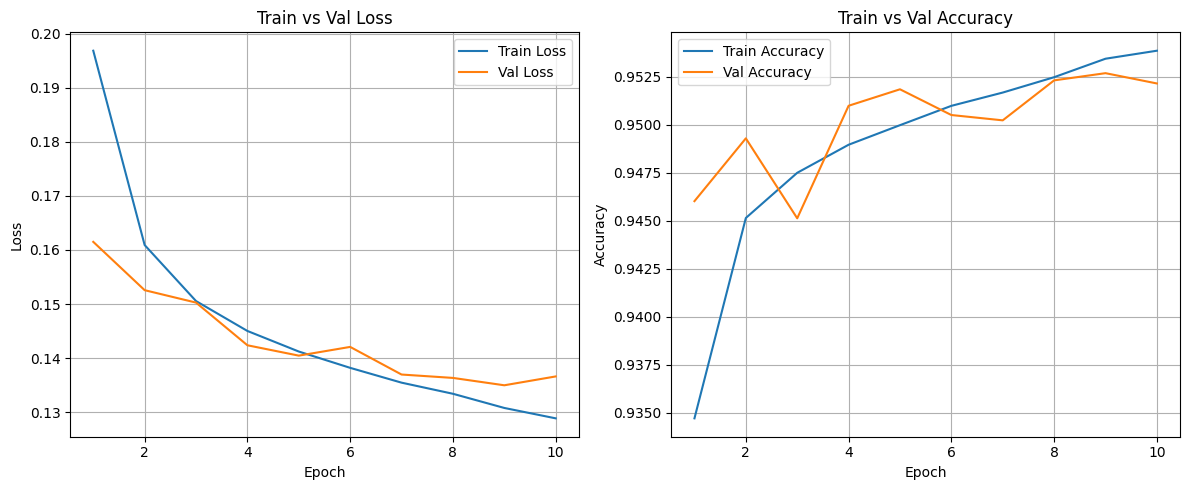

In [28]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluation Metrics

In [29]:
T_eval = 10  # stochastic forward passes for evaluation
sample_flag = (T_eval > 1)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_dataloader, desc="Collecting for Confusion Matrix"):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        # Multiple stochastic passes & mean logits
        outputs, _ = model(x_batch, sample=True, n_samples=T)  # (T,B,C)

        if sample_flag:
            outputs = outputs.mean(dim=0)  # (B, C)

        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# ===== Metrics =====
# Cohen's Kappa
kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
print(f"Cohen's Kappa: {kappa:.4f}")

# Per-class F1
per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
print('Per Class F1:', per_class_f1)

# Average F1
macro_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
print(f"Macro (Avg) F1: {macro_f1:.4f}")

Cohen's Kappa: 0.9204
Per Class F1: [0.90010455 0.96954196 0.95364324]
Macro (Avg) F1: 0.9411


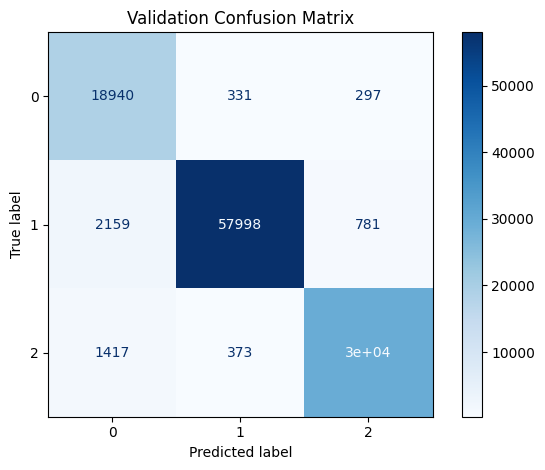

In [30]:
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

<hr>